# Value Based Clustering

The goal is to identify which customers contribute the most financially.

### 2. Number of Clusters

      2.1 Evaluate the Number of Clusters with Hierarchical Clustering

      2.2 Evaluate the Number of Clusters with K-Means

### 5. Cluster Profile (Best Result)

      5.1 Number of Customers per Cluster

      5.2 City as a Factor

      5.3 Age as a Factor

      5.4 Paymenth Methods as  Factor

      5.5 Comparing Clusters with the Entire Dataset

      5.6 Final Cluster Profile

In [1]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [2]:
df_value_based = pd.read_csv("df_ready_for_clustering.csv")
df_value_based.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [3]:
df_value_based.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [4]:
value_features = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'TotalFlights',

    'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun',
    'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec'
]

df_value_based = df_value_based[value_features]


In [5]:
# Transform the features in df_value_based as needed (e.g., scaling, normalization)
scaler = StandardScaler()
df_value_based_scaled = scaler.fit_transform(df_value_based)  

df_value_based = pd.DataFrame(df_value_based_scaled, columns=value_features)

## PCA

Let's apply PCA to reduce dimensionality.

In [6]:
# Keep enough components to explain 85–95% variance
pca = PCA(n_components=None)  # start with all components
pca_components = pca.fit_transform(df_value_based)

# Create dataframe of components
pca_cols = [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]
df_pca = pd.DataFrame(pca_components, columns=pca_cols)


In [7]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
print(cum_var)
# keep components explaining 85% variance
n_keep = np.argmax(cum_var >= 0.85) + 1
print("Components selected:", n_keep)

[0.16930791 0.26057391 0.33238288 0.39418621 0.44848602 0.50132613
 0.55202524 0.60174605 0.64983878 0.69749017 0.7438293  0.78929279
 0.83329119 0.8766132  0.91826698 0.94865878 0.97679968 0.99132493
 1.        ]
Components selected: 14


In [8]:
pca_final = PCA(n_components=n_keep)
pca_data = pca_final.fit_transform(df_value_based)

df_pca_final = pd.DataFrame(pca_data,
                            columns=[f"PC{i+1}" for i in range(n_keep)])

# Hierarchical Clustering 

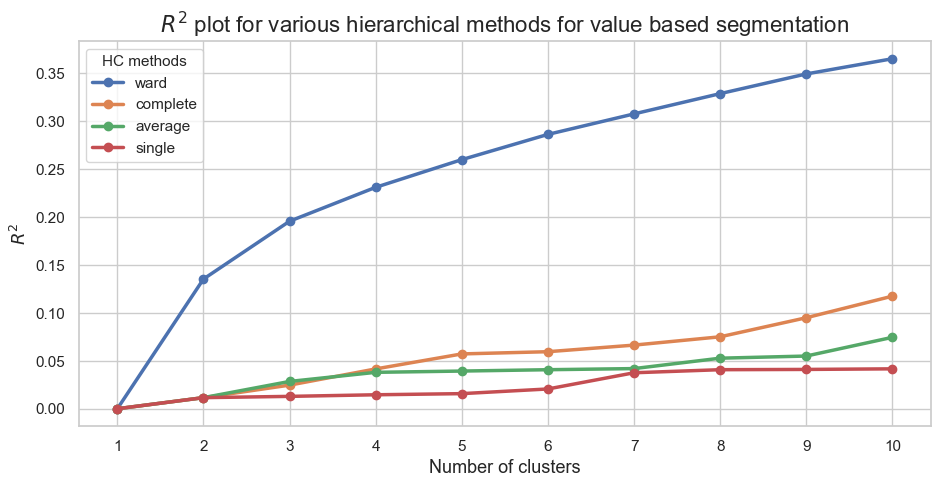

In [9]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_pca_final.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df_pca_final[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()


Ward linkage is the best method, since it gets the best r2 across all clusters.

In [11]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_pca_final, method="ward") 

In [12]:
linkage_matrix.shape

# Column	Meaning
# 0	        Index of first cluster merged
# 1	        Index of second cluster merged
# 2	        Distance between them at merge (height in dendrogram)
# 3	        Number of original observations contained in the new cluster

(16573, 4)

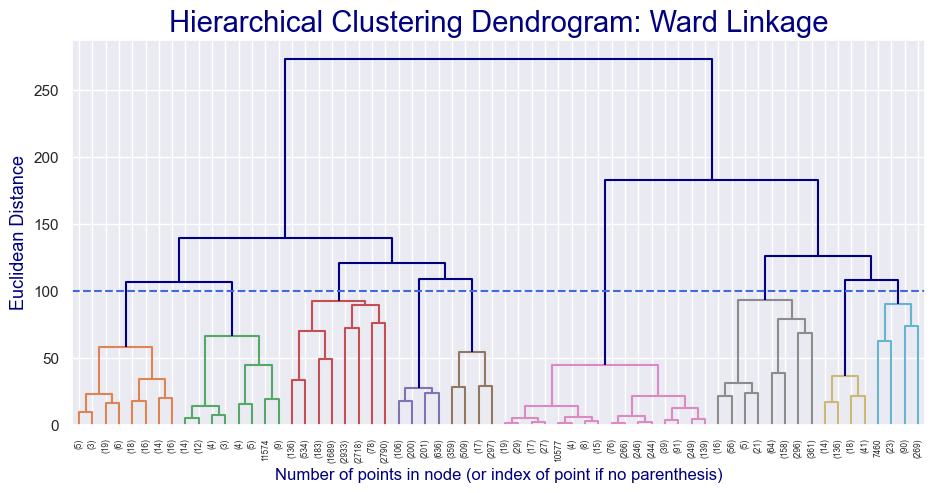

In [ ]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

let's try with nclusters = 2 and nclusters=3

In [14]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 2
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels2 = hclust.fit_predict(df_pca_final)

In [15]:
df_concat = pd.concat([
    df_pca_final, 
    pd.Series(hc_labels2, name='labels', index=df_pca_final.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1
PC1,-3.139060,0.704810
PC2,0.012554,-0.002819
PC3,-0.313216,0.070326
PC4,-0.220823,0.049581
PC5,-0.091696,0.020588
PC6,0.033748,-0.007577
PC7,0.082560,-0.018537
PC8,-0.052495,0.011787
PC9,0.062551,-0.014044
PC10,-0.083636,0.018779


In [16]:
# Features used for clustering
X = df_pca_final

# Compute metrics
silhouette = silhouette_score(X, hc_labels2)
calinski_harabasz = calinski_harabasz_score(X, hc_labels2)
davies_bouldin = davies_bouldin_score(X, hc_labels2)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.3012511486683114
Calinski-Harabasz Index: 2594.2858574171846
Davies-Bouldin Index: 1.913492535290571


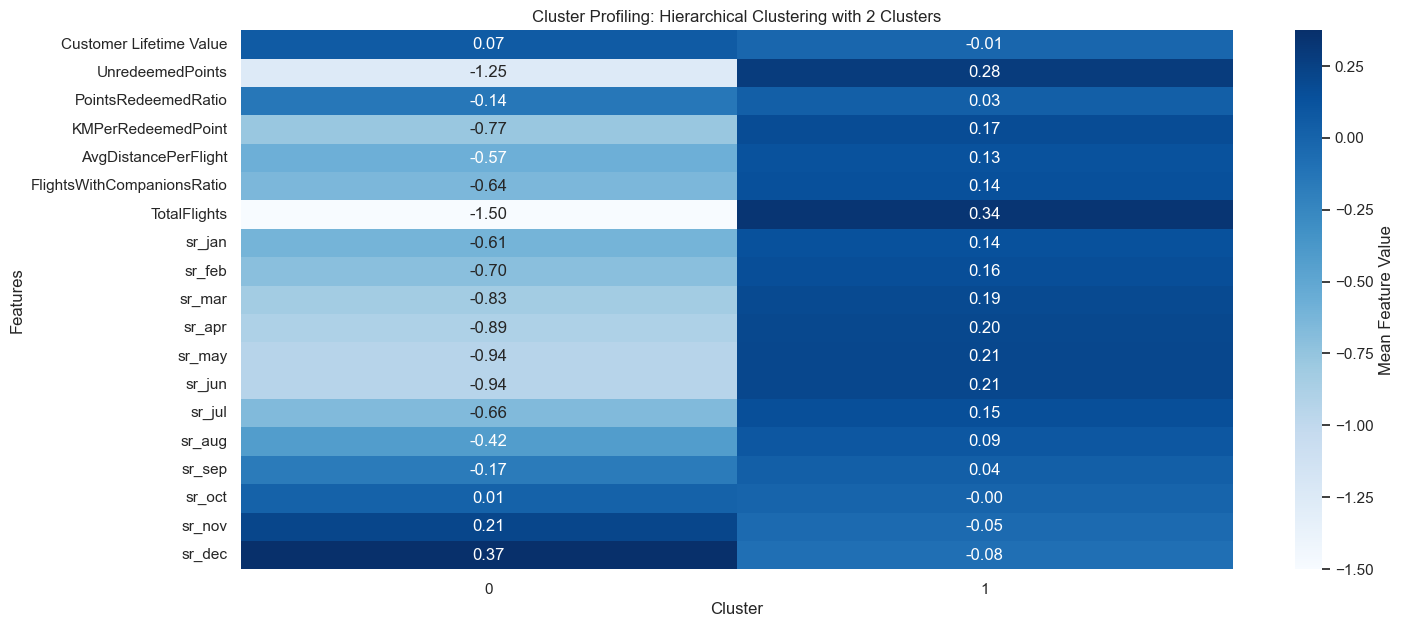

In [19]:
X = df_value_based.copy()
X['labels'] = hc_labels2

cluster_means = X.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [20]:
# 3 cluster solution

linkage = "ward" 
distance = "euclidean" 
n_clusters = 3
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels3 = hclust.fit_predict(df_pca_final)

In [21]:
df_concat = pd.concat([
    df_pca_final, 
    pd.Series(hc_labels3, name='labels', index=df_pca_final.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
PC1,0.704810,-2.450802,-3.873671
PC2,-0.002819,2.116745,-2.233348
PC3,0.070326,-0.651880,0.048256
PC4,0.049581,-0.384381,-0.046250
PC5,0.020588,-0.042791,-0.143895
PC6,-0.007577,0.129344,-0.068285
PC7,-0.018537,0.194388,-0.036800
PC8,0.011787,-0.200395,0.105366
PC9,-0.014044,0.060791,0.064429
PC10,0.018779,-0.233545,0.076370


In [22]:
# Features used for clustering
X = df_pca_final

# Compute metrics
silhouette = silhouette_score(X, hc_labels3)
calinski_harabasz = calinski_harabasz_score(X, hc_labels3)
davies_bouldin = davies_bouldin_score(X, hc_labels3)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.27738848559827967
Calinski-Harabasz Index: 2016.04442804791
Davies-Bouldin Index: 1.8838892570540418


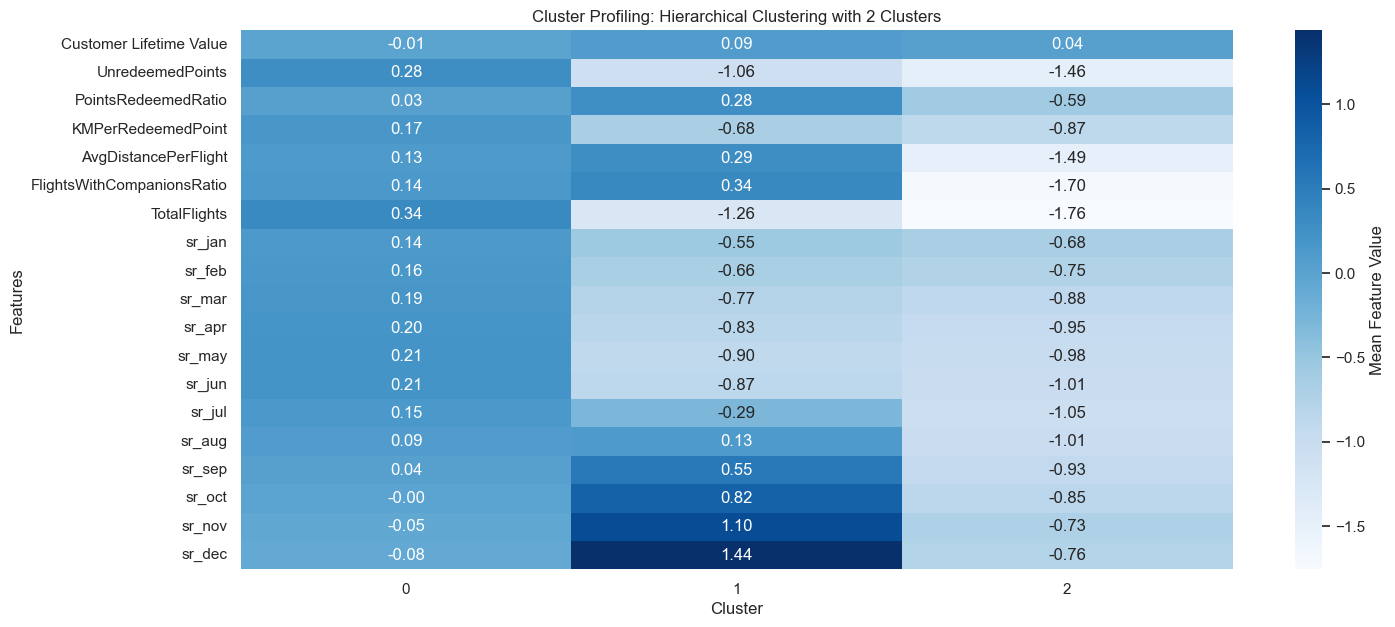

In [23]:
Y = df_value_based.copy()
Y['labels'] = hc_labels3

cluster_means = Y.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [24]:
## See crosstab of 3 vs 2

pd.crosstab(
    pd.Series(hc_labels3, name='hc3_labels', index=df_pca_final.index),
    pd.Series(hc_labels2, name='hc2_labels', index=df_pca_final.index),
    )

hc2_labels,0,1
hc3_labels,,
0,0,13535
1,1569,0
2,1470,0


# K-means Clustering 

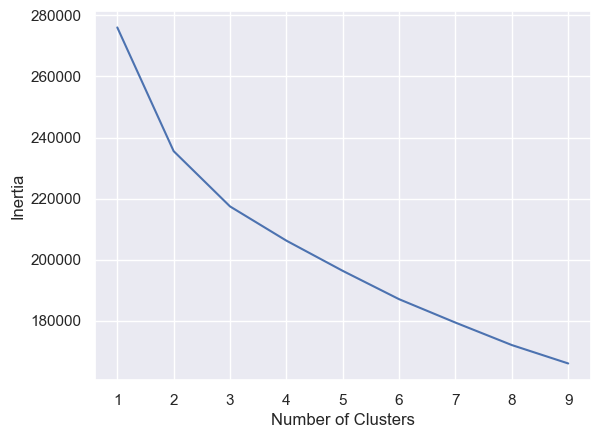

In [25]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df_pca_final)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

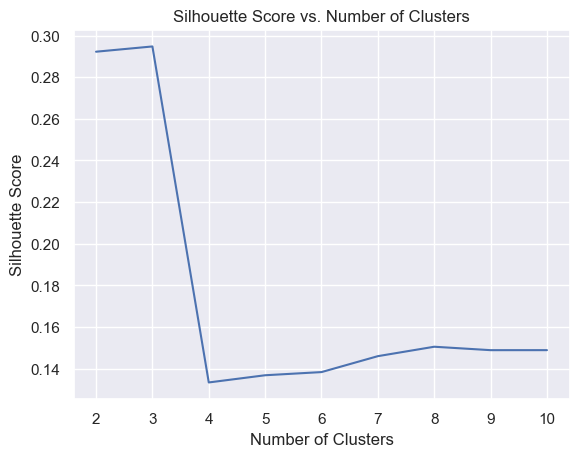

In [26]:
s_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=94)  # Set random_state for reproducibility
    kmeans.fit(df_pca_final)
    score = silhouette_score(df_pca_final, kmeans.labels_)
    s_scores.append(score)

# Plot silhouette scores dynamically
plt.figure()  # Create a new figure for each iteration
plt.plot(n_clusters, s_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters')
plt.show()

**Through the elbow graph, we can see that the optimal number of clusters is 3, and the silhouette score we can see that the optimal number of clusters with the k means is 2.**

cluster,0,1
Customer Lifetime Value,0.038716,-0.005205
UnredeemedPoints,-1.048288,0.140920
PointsRedeemedRatio,0.292635,-0.039338
KMPerRedeemedPoint,-0.645426,0.086764
AvgDistancePerFlight,0.467524,-0.062849
FlightsWithCompanionsRatio,0.459817,-0.061812
TotalFlights,-1.214892,0.163316
sr_jan,-0.467296,0.062818
sr_feb,-0.601452,0.080852
sr_mar,-0.725432,0.097519


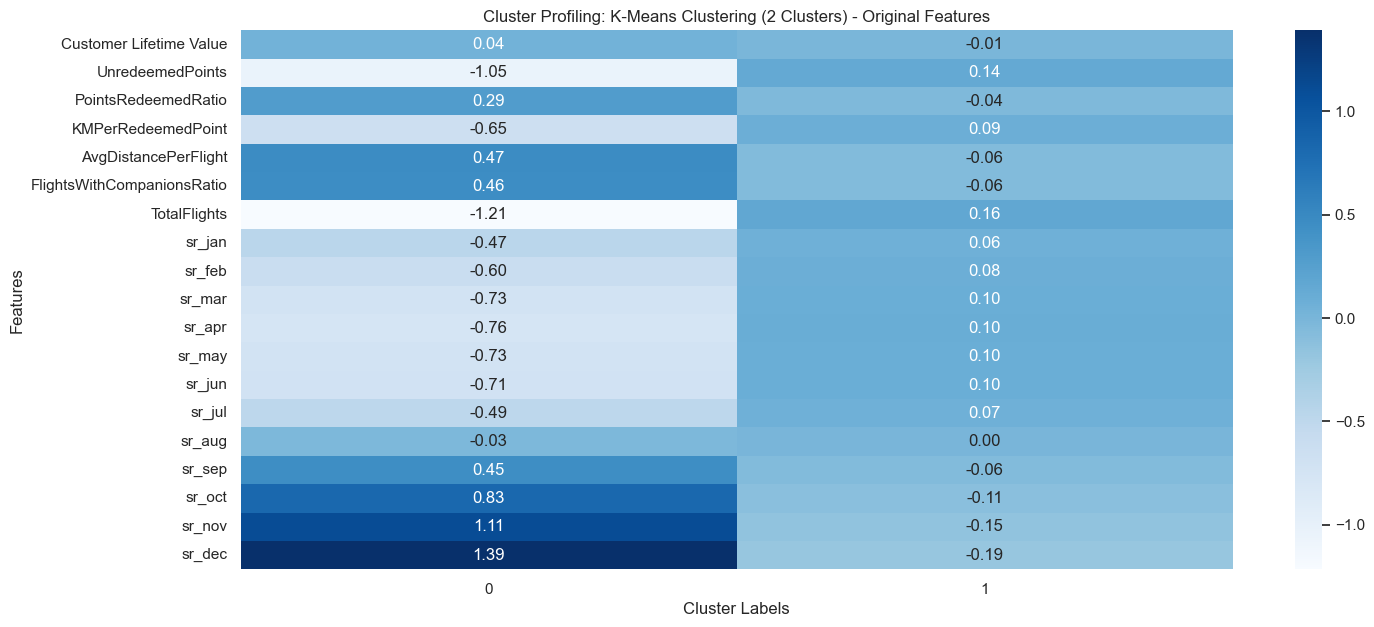

In [30]:
km = KMeans(n_clusters=2, init="k-means++", random_state=94)
km_labels_2 = km.fit_predict(df_pca_final)

df_value_based_with_clusters = df_value_based.copy()
df_value_based_with_clusters['cluster'] = km_labels_2

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters) - Original Features")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2
Customer Lifetime Value,0.054815,-0.011882,0.026286
UnredeemedPoints,-1.447154,0.366355,-0.960813
PointsRedeemedRatio,-0.590255,0.023007,0.248673
KMPerRedeemedPoint,-0.872434,0.225382,-0.602142
AvgDistancePerFlight,-1.442187,0.103837,0.366283
FlightsWithCompanionsRatio,-1.687045,0.128818,0.391222
TotalFlights,-1.743861,0.430156,-1.100487
sr_jan,-0.409878,0.136784,-0.439446
sr_feb,-0.590067,0.179414,-0.543952
sr_mar,-0.810752,0.232912,-0.678467


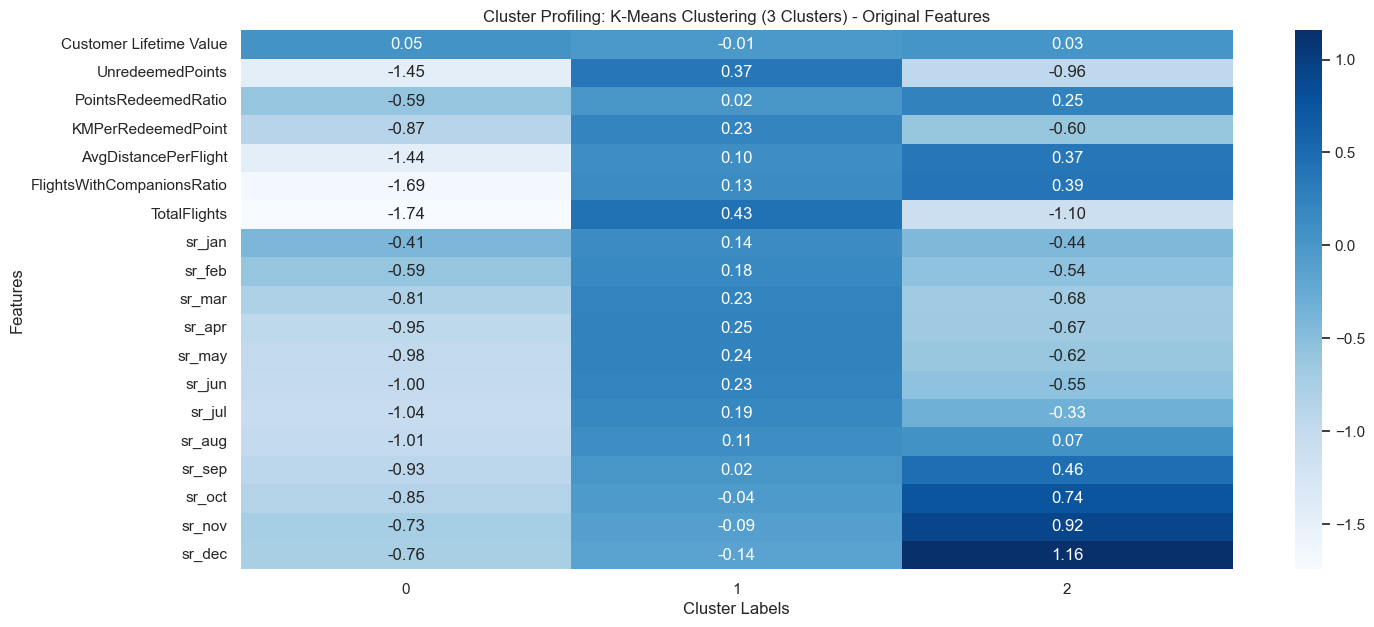

In [31]:
km = KMeans(n_clusters=3, init="k-means++", random_state=94)
km_labels_3 = km.fit_predict(df_pca_final)

df_value_based_with_clusters = df_value_based.copy()
df_value_based_with_clusters['cluster'] = km_labels_3

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (3 Clusters) - Original Features")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


In [29]:
# Features used for clustering
X = df_pca_final
# Compute metrics for KMeans with 2 clusters
kmeans_2_silhouette = silhouette_score(X, km_labels_2)
kmeans_2_calinski_harabasz = calinski_harabasz_score(X, km_labels_2)
kmeans_2_davies_bouldin = davies_bouldin_score(X, km_labels_2)
# Compute metrics for KMeans with 3 clusters
kmeans_3_silhouette = silhouette_score(X, km_labels_3)
kmeans_3_calinski_harabasz = calinski_harabasz_score(X, km_labels_3)
kmeans_3_davies_bouldin = davies_bouldin_score(X, km_labels_3)
# Create a comparison table
comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (2 Clusters)", "Hierarchical (3 Clusters)", "K-Means (2 Clusters)", "K-Means (3 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels2), silhouette_score(X, hc_labels3), kmeans_2_silhouette, kmeans_3_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels2), calinski_harabasz_score(X, hc_labels3), kmeans_2_calinski_harabasz, kmeans_3_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels2), davies_bouldin_score(X, hc_labels3), kmeans_2_davies_bouldin, kmeans_3_davies_bouldin]
})
comparison_table.head()

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (2 Clusters),0.301251,2594.285857,1.913493
1,Hierarchical (3 Clusters),0.277388,2016.044428,1.883889
2,K-Means (2 Clusters),0.296967,1522.970528,2.291061
3,K-Means (3 Clusters),0.297388,2232.280232,1.919896


### Conclusion 
    
    Hierarchical clustering with 2 clusters outperforms K-Means with 2 clusters in terms of Silhouette Score (0.301 vs 0.297) and Calinski-Harabasz Index (2594 vs 1523), indicating slightly better cluster separation and compactness. The Davies-Bouldin Index is comparable for both methods.

    In addition, in terms of insights for customer segmentation analysis and marketing strategies, the result of Hierarchical clustering with 3 clusters provides more granularity by splitting the smaller cluster into two meaningful sub-clusters, revealing patterns that are more actionable. For this reason, Hierarchical clustering with 3 clusters will be used.




Let's check for DBSCAN since it works well with outliers and works with dense regions.

KMeans has some limitations, such as assuming globular clusters and sensitivity to outliers, so that's why we are going to test DBSCAN, Mean Shift and GMM.

DBSCAN will be use to detect VIP Customers.

## Mean Shift

In [ ]:
bandwidth = estimate_bandwidth(df_pca_final, quantile=0.3, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_pca_final)

In [ ]:
n_clusters = len(np.unique(ms_labels))
print(pd.Series(ms_labels).value_counts().sort_index())

0     14228
1      1964
2       188
3        10
4         4
5        46
6         3
7        15
8         4
9        64
10        2
11        3
12        6
13        1
14        1
15        1
16        5
17        1
18        1
19        1
20        1
21       22
22        1
23        1
24        1
Name: count, dtype: int64


In [ ]:
#Get the score of r^2
r2_mshift = get_rsq(
    pd.concat([df_pca_final, pd.Series(ms_labels, name='labels', index=df_pca_final.index)], axis=1),
    value_features,
    'labels'
)
print("R² for Mean Shift Clustering:", r2_mshift)

R² for Mean Shift Clustering: 0.23945404047024826


With quantile = 0.3 we have 24 clusters wich are a lot. We will try to reduuce the number merging tiny clusters with similar behaviour.

In [ ]:
from collections import Counter

counts = Counter(ms_labels)
threshold = 0.01 * len(ms_labels)  # clusters with >1% of data are "large"
large_clusters = [k for k, v in counts.items() if v > threshold]
print("Large clusters:", large_clusters)

from sklearn.metrics import pairwise_distances_argmin_min

new_labels = ms_labels.copy()

for i, lbl in enumerate(ms_labels):
    if lbl not in large_clusters:
        # Find nearest large cluster centroid
        nearest, _ = pairwise_distances_argmin_min(
            df_pca_final[i].reshape(1, -1),  # X_pca = your PCA-reduced data
            df_pca_final[np.isin(ms_labels, large_clusters)]
        )
        new_labels[i] = ms_labels[np.isin(ms_labels, large_clusters)][nearest[0]]


Large clusters: [np.int64(0), np.int64(1), np.int64(2)]


## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=2.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(df_pca_final)

df_pca_final['VIP_Flag'] = dbscan_labels == -1  


print("VIP / outlier counts:")
print(df_pca_final['VIP_Flag'].value_counts())

VIP / outlier counts:
VIP_Flag
False    14506
True      2068
Name: count, dtype: int64


## GMM

In [ ]:
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_value_based)
    models.append(model)

bic_values = [m.bic(df_pca_final) for m in models]
aic_values = [m.aic(df_pca_final) for m in models]

plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

## 5. Cluster Profiling

                    Customer Lifetime Value  UnredeemedPoints  \
K_Means_2_clusters                                              
0                                 -0.010035          0.303879   
1                                  0.041251         -1.249156   

                    PointsRedeemedRatio  KMPerRedeemedPoint  \
K_Means_2_clusters                                            
0                              0.046161            0.189408   
1                             -0.189755           -0.778598   

                    AvgDistancePerFlight  FlightsWithCompanionsRatio  \
K_Means_2_clusters                                                     
0                               0.138789                    0.163232   
1                              -0.570519                   -0.670999   

                    TotalFlights    sr_jan    sr_feb    sr_mar    sr_apr  \
K_Means_2_clusters                                                         
0                       0.362938  0.151141  0

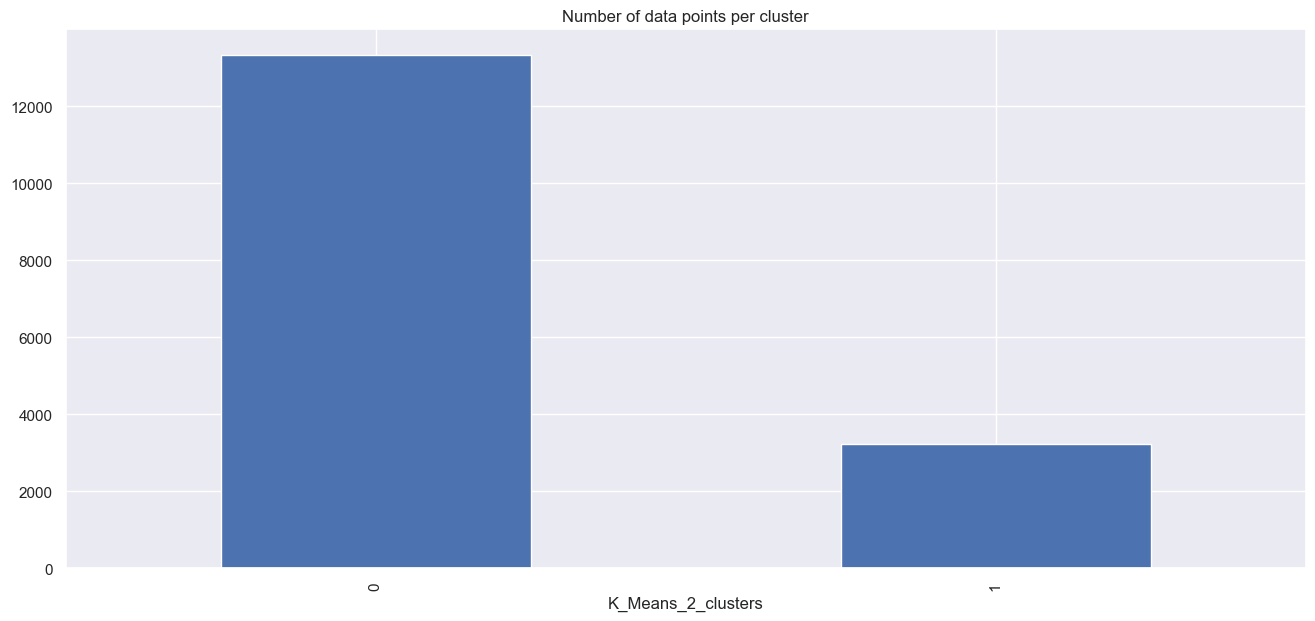

In [ ]:

km = KMeans(n_clusters=2, random_state=42)
df_value_based['K_Means_2_clusters'] = km.fit_predict(df_value_based)

cluster_means_scaled = df_value_based.groupby('K_Means_2_clusters').mean()
print(cluster_means_scaled)

if 'scaler' in globals():
    centroids = km.cluster_centers_
    real_centroids = scaler.inverse_transform(centroids)
    print(pd.DataFrame(real_centroids, columns=df_value_based.columns[:-1]))

fig, ax = plt.subplots(figsize=(16,7))
df_value_based['K_Means_2_clusters'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Number of data points per cluster')
plt.show()